In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.plotting import andrews_curves
from statsmodels.nonparametric.smoothers_lowess import lowess
red_wine=pd.read_csv("winequality-red.csv",sep=";")
white_wine=pd.read_csv("winequality-white.csv",sep=";")
#Column renaming according to usual conventions
red_wine.columns=red_wine.columns.str.replace(" ","_")
white_wine.columns=white_wine.columns.str.replace(" ","_")
red_wine["type"]="red"
white_wine["type"]="white"
#Create a variable for total acidity, to compare against pH
red_wine["total_acid"]=(red_wine["fixed_acidity"]+red_wine["volatile_acidity"]+red_wine["citric_acid"])
white_wine["total_acid"]=white_wine["fixed_acidity"]+white_wine["volatile_acidity"]+white_wine["citric_acid"]

In [ ]:
red_wine["quality_label"] = red_wine["quality"].apply(lambda value: "low"
if value <= 5 else "medium"
if value <= 7 else "high")
white_wine["quality_label"]=white_wine["quality"].apply(lambda value: "low"
if value<=5 else "medium"
if value<=7 else "high")
red_wine["quality_label"]=pd.Categorical(red_wine["quality_label"],categories=["low","medium","high"])
white_wine["quality_label"]=pd.Categorical(white_wine["quality_label"],categories=["low","medium","high"])

In [ ]:
conr=red_wine[["residual_sugar","total_sulfur_dioxide","sulphates","alcohol","volatile_acidity","quality"]].describe().applymap("{:.2f}".format)
conw=white_wine[["residual_sugar","total_sulfur_dioxide","sulphates","alcohol","volatile_acidity","quality"]].describe().applymap("{:.2f}".format)
keys=["Red Whine Statistics","White Wine Statistics"]
wines_sum=pd.concat((conr,conw),axis=1, keys=keys)
del conr,conw,keys
wines_sum

In [ ]:
#Heatmap for red wines
conr=red_wine.drop(["type","quality_label"],axis=1).corr()
conr.style.background_gradient(cmap="hot")

In [ ]:
#Heatmap for white wines
conw=white_wine.drop(["type","quality_label"],axis=1).corr()
conw.style.background_gradient(cmap="hot")

In [ ]:
wines=pd.concat([red_wine,white_wine])
wines=wines.sample(frac=1,random_state=42).reset_index(drop=True)

In [ ]:
fig= plt.subplots(figsize=(5,5),facecolor="darkgrey")
wines["type"].value_counts().plot(kind="pie", autopct="%.1f%%", wedgeprops={"alpha":0.5}, colors=["yellow","red"], title="Distribution of wines based on colour")

In [ ]:
tempr=pd.DataFrame(data={"quality_label":["low","medium","high"],"count":red_wine.value_counts(subset="quality_label")})
tempw=pd.DataFrame(data={"quality_label":["low","medium","high"],"count":white_wine.value_counts(subset="quality_label")})
#Normalized for better understanding due to the radically different dataframe sizes
fig, axes = plt.subplots(1,2, sharey=True, squeeze=True, facecolor="snow")
tempr["count"]=preprocessing.minmax_scale(tempr["count"], feature_range=(0.1, 1))
tempw["count"]=preprocessing.minmax_scale(tempw["count"], feature_range=(0.1, 1))
tempr["count"].plot(kind='bar',ax=axes[0],color=["dimgray"]); axes[0].set_title('Red'); axes[0].set_xlabel("Wine quality")
tempw["count"].plot(kind='bar',ax=axes[1],color=["dimgray"]); axes[1].set_title('White'); axes[1].set_xlabel("Wine quality")

In [ ]:
#x,y will be the y-axis variables, z for x-axis, winetype is the type-specific dataframe and out takes boolean values for outliers
def boxplotter(x,y,z,winetype,out):
    fig, axes = plt.subplots(1,2, figsize=(10,10),facecolor="snow")
    if len(winetype)==1599:
        title="Red Wines"
    else:
        title="White Wines"
    temp=winetype[[z,x]]
    temp.boxplot(by=z, ax=axes[0],showfliers=out,notch=True,patch_artist=True,color="dimgray");axes[0].set_title(""); axes[0].set_xlabel(z); axes[0].set_ylabel(x)
    temp=winetype[[z,y]]
    temp.boxplot(by=z, ax=axes[1],showfliers=out,notch=True,patch_artist=True,color="dimgray");axes[1].set_title(""); axes[1].set_xlabel(z); axes[1].set_ylabel(y)
    fig.suptitle(title)

In [ ]:
boxplotter("alcohol","pH","quality_label",red_wine,False)
boxplotter("alcohol","pH","quality_label",white_wine,False)

In [ ]:
#Takes a,b variables for x and y axis respectively.
def plotter(a,b):
    fig, axes = plt.subplots(1,2, figsize=(10,6),facecolor="snow")
    x=sns.regplot(ax=axes[0],x=red_wine[a],y=red_wine[b],lowess=True,scatter_kws={"color":"crimson"},line_kws={"color":"black"}).set(title="Red wines")
    y=sns.regplot(ax=axes[1],x=white_wine[a],y=white_wine[b],lowess=True,scatter_kws={"color":"crimson"},line_kws={"color":"black"}).set(title="White wines")
    return x,y

In [ ]:
plotter("total_acid","pH")
#The rate of change is much higher for red wines than white ones

In [ ]:
plotter("total_acid","quality")
plotter("fixed_acidity","quality")
plotter("volatile_acidity","quality")
plotter("citric_acid","quality")
#Comparing quality to different acidity indicators we see that white wines' acidity excepty citric are inversely correlated to quality
#Red wines are much more resilient to higher acidity values
#The reason is the presence of tanins in red wines hides/enhances the acidity, while their absence in white ones makes it more apparent
#Volatile acidity seems to be a special case, as it is the only acidity marker that is actively inversely propotional to quality on both wines

In [ ]:
plotter("chlorides","quality")
#As the quantity of chlorides increase, the quality decreases
#Not surprising considering chlorides are basically salts

In [ ]:
#With the removal of a single outlying value the effect of free SO2 in white wines becomes less pronounced,
#which is expected considering that there's no scentific literature to support a quality decrease because of them
plotter("free_sulfur_dioxide","quality")
#SO2 is antioxidant, and its presence in free form can help prevent oxidation and spoiling
#Red wines which are generally sotred longer than white ones benefit in quality with the presence of free SO2
#In white wines, which are not usually aged, the benefits of free SO2 are counteracted by general consumer attitudes towards S02,
#holding it responsible for hangovers.

In [ ]:
#We again remove the outlier, though even with it the results are the same, if a bit more extreme
plotter("total_sulfur_dioxide","quality")
#Total SO2 is directly correlated with free SO2 (naturally), but in high quantities, the bound SO2 can add
#unpleasant metallic and/or chemical taste to the wine. That much can be seen in the graphs

In [ ]:
plotter("alcohol","quality")
#Simply put, quality is directly related to alcoholic content, despite the fact that stronger wines are not recommended for food pairing
#since they dilute the taste
#It seems that costumers prefer more potent wines

In [ ]:
plotter("alcohol","density")
#The lower the density the higher the alcoholic value. Expected since alcohol has lower density than water

In [ ]:
plotter("density","quality")
#Higher densities lead to worse quality. To be expected since that means lower alcohol lead to worse quality

In [ ]:
plotter("volatile_acidity","quality")
#We see that more acidic red wines are denser. The effect is much less pronounced in white ones 

In [ ]:
names=["residual_sugar","total_sulfur_dioxide","sulphates","alcohol","volatile_acidity","quality","type"]
features=["residual_sugar","total_sulfur_dioxide","sulphates","alcohol","volatile_acidity","quality"]
temp=wines[names]
temp.replace({"white":0,"red":1},inplace=True)
x=temp.loc[:,features].values
y=temp.loc[:,["type"]].values
x=StandardScaler().fit_transform(x)
pca=PCA(n_components=2)
principalComponents=pca.fit_transform(x)
principaldf=pd.DataFrame(data=principalComponents, columns=["prin1","prin2"])
finaldf=pd.concat([principaldf,temp[["type"]]],axis=1)
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
ax.set_xlabel("Pr.Com1")
ax.set_ylabel("Pr.Com2")
ax.set_title("2 com.PCA")
targets=[0,1]
colors=["y","r"]
for target,color in zip(targets,colors):
    indicestokeep=finaldf["type"]==target
    ax.scatter(finaldf.loc[indicestokeep, "prin1"],finaldf.loc[indicestokeep, "prin2"],c=color,s=50,alpha=0.2)

In [ ]:
def colourcoder(x,y):
    colours={"white":"y","red":"r"}
    fig,ax=plt.subplots()
    ax.scatter(wines[x],wines[y],c=wines["type"].map(colours),alpha=0.3)

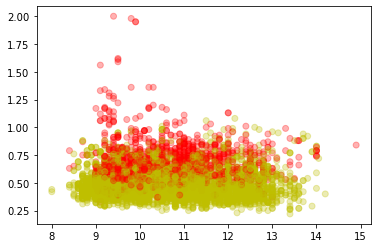

In [28]:
colourcoder("alcohol","sulphates")